<a href="https://colab.research.google.com/github/AsalNouri/Fall-2020/blob/master/Biostatistics_Lab_5_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#If training is slow try restarting the notebook and re-run the code

In [1]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-xpwkohmr
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-xpwkohmr
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=7325 sha256=278789b9a0d53cdadae6fb8f058692ae67d8d2106937adb286bcba88420d20af
  Stored in directory: /tmp/pip-ephem-wheel-cache-oe3f_0j2/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
!pip install flashtorch
!pip install barbar

  Created wheel for flashtorch: filename=flashtorch-0.1.3-cp36-none-any.whl size=26248 sha256=7efd700b38421eaac57bcf0ae9fe0195ca0742f485051384e2b43b7492532318
  Stored in directory: /root/.cache/pip/wheels/03/6d/b1/2d3c5987b69e900fcceceeef39d3ed92dfe46ba1359b9c79f8
Successfully built flashtorch


In [3]:
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Create new folder on your google drive like below:

In [6]:
os.chdir('/content/drive/MyDrive/Data1/flowers102/')

In [7]:
#This code will download the dataset
!wget https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip 'flower_data.zip'

--2020-12-19 18:15:29--  https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘Oxford-102_Flower_dataset_labels.txt.1’

Oxford-102_Flower_d 100%[===================>]   1.57K  --.-KB/s    in 0.001s  

2020-12-19 18:15:29 (2.08 MB/s) - ‘Oxford-102_Flower_dataset_labels.txt.1’ saved [1608/1608]

--2020-12-19 18:15:29--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.16.75
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.16.75|:443... connected.
HTTP request sent, awaiting respons

In [9]:
dataset_labels = pd.read_csv('Oxford-102_Flower_dataset_labels.txt',header=None)[0]

In [10]:
data_dir = '/content/drive/My Drive/Data1/flowers102/flower_data/'

In [11]:
mean = np.array([0.485, 0.456, 0.406]) #parameters for applying iage transformation to the code
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [12]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']} #images from train and valid folders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'valid']} #creates datasets for training
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
dataset_sizes

{'train': 6552, 'valid': 818}

In [14]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

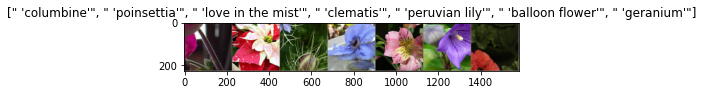

In [15]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:7]
classes = classes[:7] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[int(class_names[x])-1] for x in classes])  #samples flowers from the train dataset 

In [16]:
from barbar import Bar

In [20]:
def train_model(model, num_epochs=25): #Creats a funtion to fine tune our model to classify flower species

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in Bar(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data) 

            loss = criterion(outputs, labels) #loss function
            loss.backward() 
            optimizer.step() 
        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train'])) #prints prediction accuracy after each training epoch
        
        scheduler.step() #tunes the gradient descent optimizer after each training epoc
    
        ###Val
        model.eval()  #evaluates the model after each training on the test dataset
        running_corrects = 0
        for inputs, labels in Bar(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [21]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [22]:
model = train_model(model, num_epochs=3) #training model for 3 epochs

Epoch:  1 / 3
6552/6552: [===============================>] - ETA 6.8s
Train  Acc: 0.39
818/818: [===============================>] - ETA 6.9s
Valid  Acc: 0.77
#######################
Epoch:  2 / 3
6552/6552: [===============================>] - ETA 0.5s
Train  Acc: 0.76
818/818: [===============================>] - ETA 0.5s
Valid  Acc: 0.92
#######################
Epoch:  3 / 3
6552/6552: [===============================>] - ETA 0.6s
Train  Acc: 0.86
818/818: [===============================>] - ETA 0.6s
Valid  Acc: 0.94
#######################


In [24]:
def visualize_model(model, num_images=16): #Creates a function to visualize the trained model
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[int(class_names[preds[j]])-1] + '     class: ' + dataset_labels[int(class_names[labels[j]])-1]
            imshow(inputs.cpu().data[j],title1)

            if index == num_images:
                return

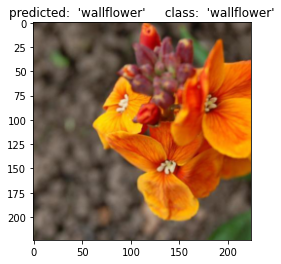

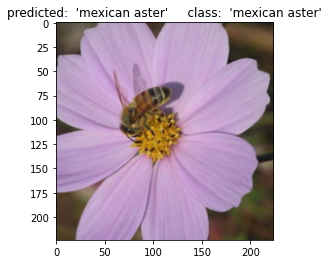

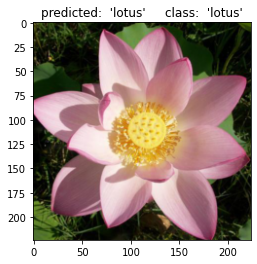

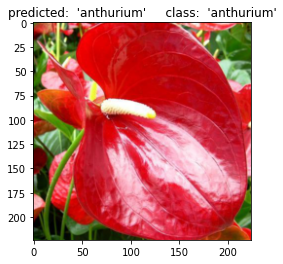

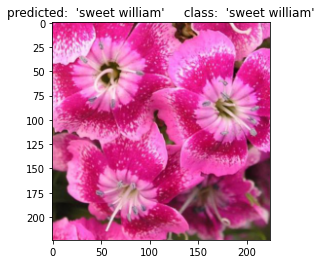

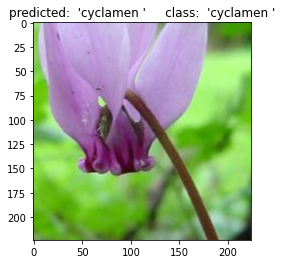

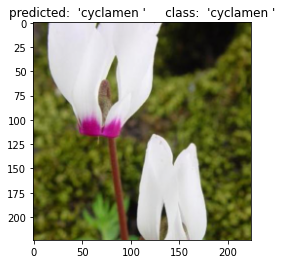

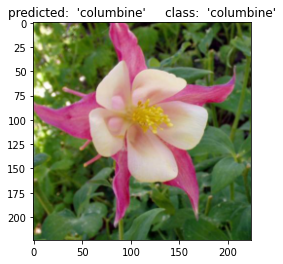

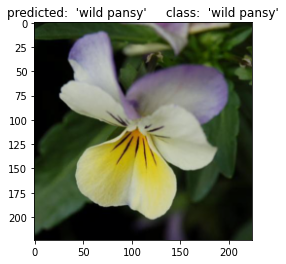

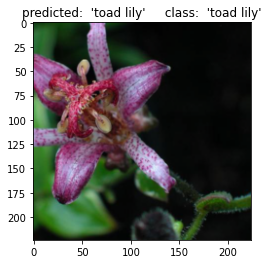

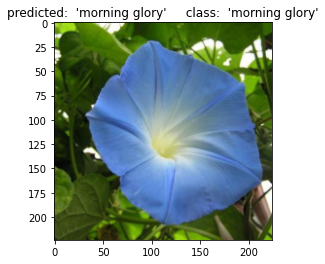

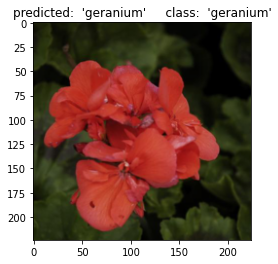

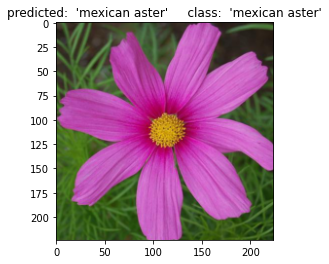

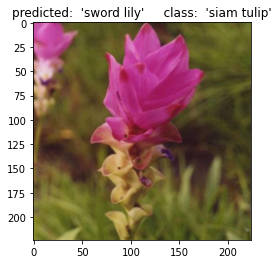

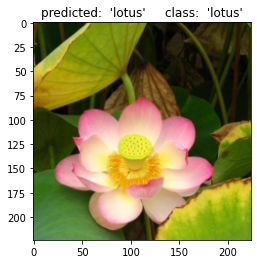

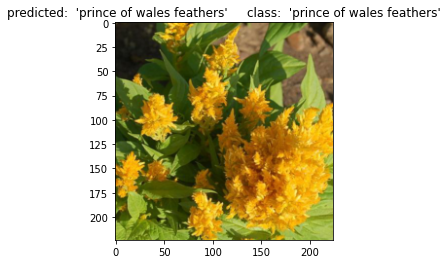

In [25]:
visualize_model(model) #Sample images to see the acuracy of prediction

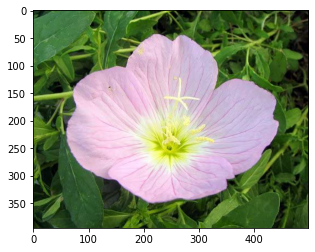

In [26]:
image = io.imread('https://images-na.ssl-images-amazon.com/images/I/51dZp-%2B4W9L._AC_.jpg') #selecting a random flower from the internet and testing how well it does
plt.imshow(image);

In [27]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [28]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [29]:
print('predicted: ' + dataset_labels[int(class_names[preds])-1])

predicted:  'pink primrose'


In [ ]:
#Testing if the model will work with a flower painting

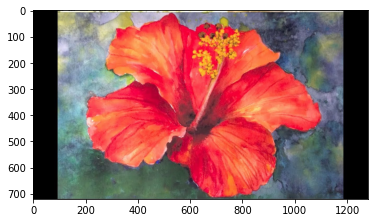

In [30]:
image = io.imread('https://i.ytimg.com/vi/RUb_RicoDsI/maxresdefault.jpg')
plt.imshow(image)

In [31]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [32]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]
print('predicted: ' + dataset_labels[int(class_names[preds])-1])

predicted:  'hibiscus'


In [ ]:
#We found that the model is only accurate with photos and can not classify drawing 